In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import random
import cv2
from pathlib import Path
from PIL import Image
import argparse
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from typing import Tuple, Optional

In [2]:
class CustomResizeWithPadding:
    def __init__(self, size: int, padding_color: Tuple[int, int, int] = (255, 255, 255)):
        self.size = size if isinstance(size, tuple) else (size, size)
        self.padding_color = padding_color

    def __call__(self, img: Image.Image) -> Image.Image:
        ratio = min(self.size[0] / img.width, self.size[1] / img.height)
        new_size = tuple(int(dim * ratio) for dim in (img.width, img.height))
        
        img = img.resize(new_size, Image.Resampling.LANCZOS)

        padded_img = Image.new('RGB', self.size, self.padding_color)

        paste_pos = ((self.size[0] - new_size[0]) // 2,
                    (self.size[1] - new_size[1]) // 2)

        padded_img.paste(img, paste_pos)
        
        return padded_img

In [3]:
class CustomAffineTransform:
    def __init__(self, degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), fill_color=(255, 255, 255)):
        self.degrees = degrees
        self.translate = translate
        self.scale = scale
        self.fill_color = fill_color

    def __call__(self, img: Image.Image) -> Image.Image:
        output = Image.new('RGB', img.size, self.fill_color)
        angle = random.uniform(-self.degrees, self.degrees)
        translate_x = random.uniform(-self.translate[0], self.translate[0]) * img.size[0]
        translate_y = random.uniform(-self.translate[1], self.translate[1]) * img.size[1]
        scale_factor = random.uniform(self.scale[0], self.scale[1])
        center = (img.size[0] * 0.5, img.size[1] * 0.5)

        matrix = img.transform(
            img.size,
            Image.Transform.AFFINE,
            [
                scale_factor * np.cos(np.deg2rad(angle)),
                -scale_factor * np.sin(np.deg2rad(angle)),
                translate_x + center[0] * (1 - scale_factor * np.cos(np.deg2rad(angle))) + center[1] * scale_factor * np.sin(np.deg2rad(angle)),
                scale_factor * np.sin(np.deg2rad(angle)),
                scale_factor * np.cos(np.deg2rad(angle)),
                translate_y + center[1] * (1 - scale_factor * np.cos(np.deg2rad(angle))) - center[0] * scale_factor * np.sin(np.deg2rad(angle))
            ],
            resample=Image.Resampling.BILINEAR,
            fillcolor=self.fill_color
        )

        output.paste(matrix)
        return output

In [4]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir: str, transform: Optional[transforms.Compose] = None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(root_dir) 
                             if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp')):
                    self.samples.append({
                        'path': os.path.join(class_dir, img_name),
                        'class': class_name,
                        'class_idx': self.class_to_idx[class_name]
                    })
    
    def __len__(self) -> int:
        return len(self.samples)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        sample = self.samples[idx]

        img = Image.open(sample['path']).convert('RGB')

        if self.transform:
            img = self.transform(img)
            
        return img, sample['class_idx']

In [5]:
transform_pipeline = transforms.Compose([
    CustomResizeWithPadding(64),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomApply([
        CustomAffineTransform(
            degrees=15,
            translate=(0.1, 0.1),
            scale=(0.9, 1.1),
            fill_color=(255, 255, 255)
        ),
    ], p=0.7),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.1,
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = EmotionDataset(
    root_dir='data',
    transform=transform_pipeline
)

dataloader = DataLoader(
    dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    drop_last=True
)

In [6]:
def visualizar_data_augmentation(dataset, samples=None, num_variacoes=5):
    if samples is None:
        samples = dataset.samples[:4]
    
    num_imagens = len(samples)

    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'grid.color': '#dddddd',
        'grid.linestyle': '-',
        'grid.linewidth': 0.5,
    })

    fig, axes = plt.subplots(num_imagens, num_variacoes + 1, figsize=(3*(num_variacoes + 1), 3*num_imagens))
    fig.suptitle('Imagem Original e Variações com Data Augmentation', fontsize=16, y=1.02)

    transform_visualizacao = transforms.Compose([
        CustomResizeWithPadding(64),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomApply([
            CustomAffineTransform(
                degrees=15,
                translate=(0.1, 0.1),
                scale=(0.9, 1.1),
                fill_color=(255, 255, 255)
            ),
        ], p=0.7),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    ])
    
    for idx, sample in enumerate(samples):
        img_original = Image.open(sample['path']).convert('RGB')
        img_original = transforms.Grayscale(num_output_channels=3)(img_original)

        axes[idx, 0].imshow(img_original, cmap='gray')
        axes[idx, 0].set_title(f'Original\n({sample["class"]})')
        axes[idx, 0].axis('off')

        for var in range(num_variacoes):
            img_aumentada = transform_visualizacao(img_original)
            axes[idx, var + 1].imshow(img_aumentada, cmap='gray')
            axes[idx, var + 1].set_title(f'Variação {var + 1}')
            axes[idx, var + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

In [7]:
def get_one_image_per_class(dataset):
    samples_by_class = {}
    for sample in dataset.samples:
        if sample['class'] not in samples_by_class:
            samples_by_class[sample['class']] = []
        samples_by_class[sample['class']].append(sample)
    
    selected_samples = []
    for class_name in sorted(samples_by_class.keys()):
        selected_samples.append(random.choice(samples_by_class[class_name]))
    
    return selected_samples

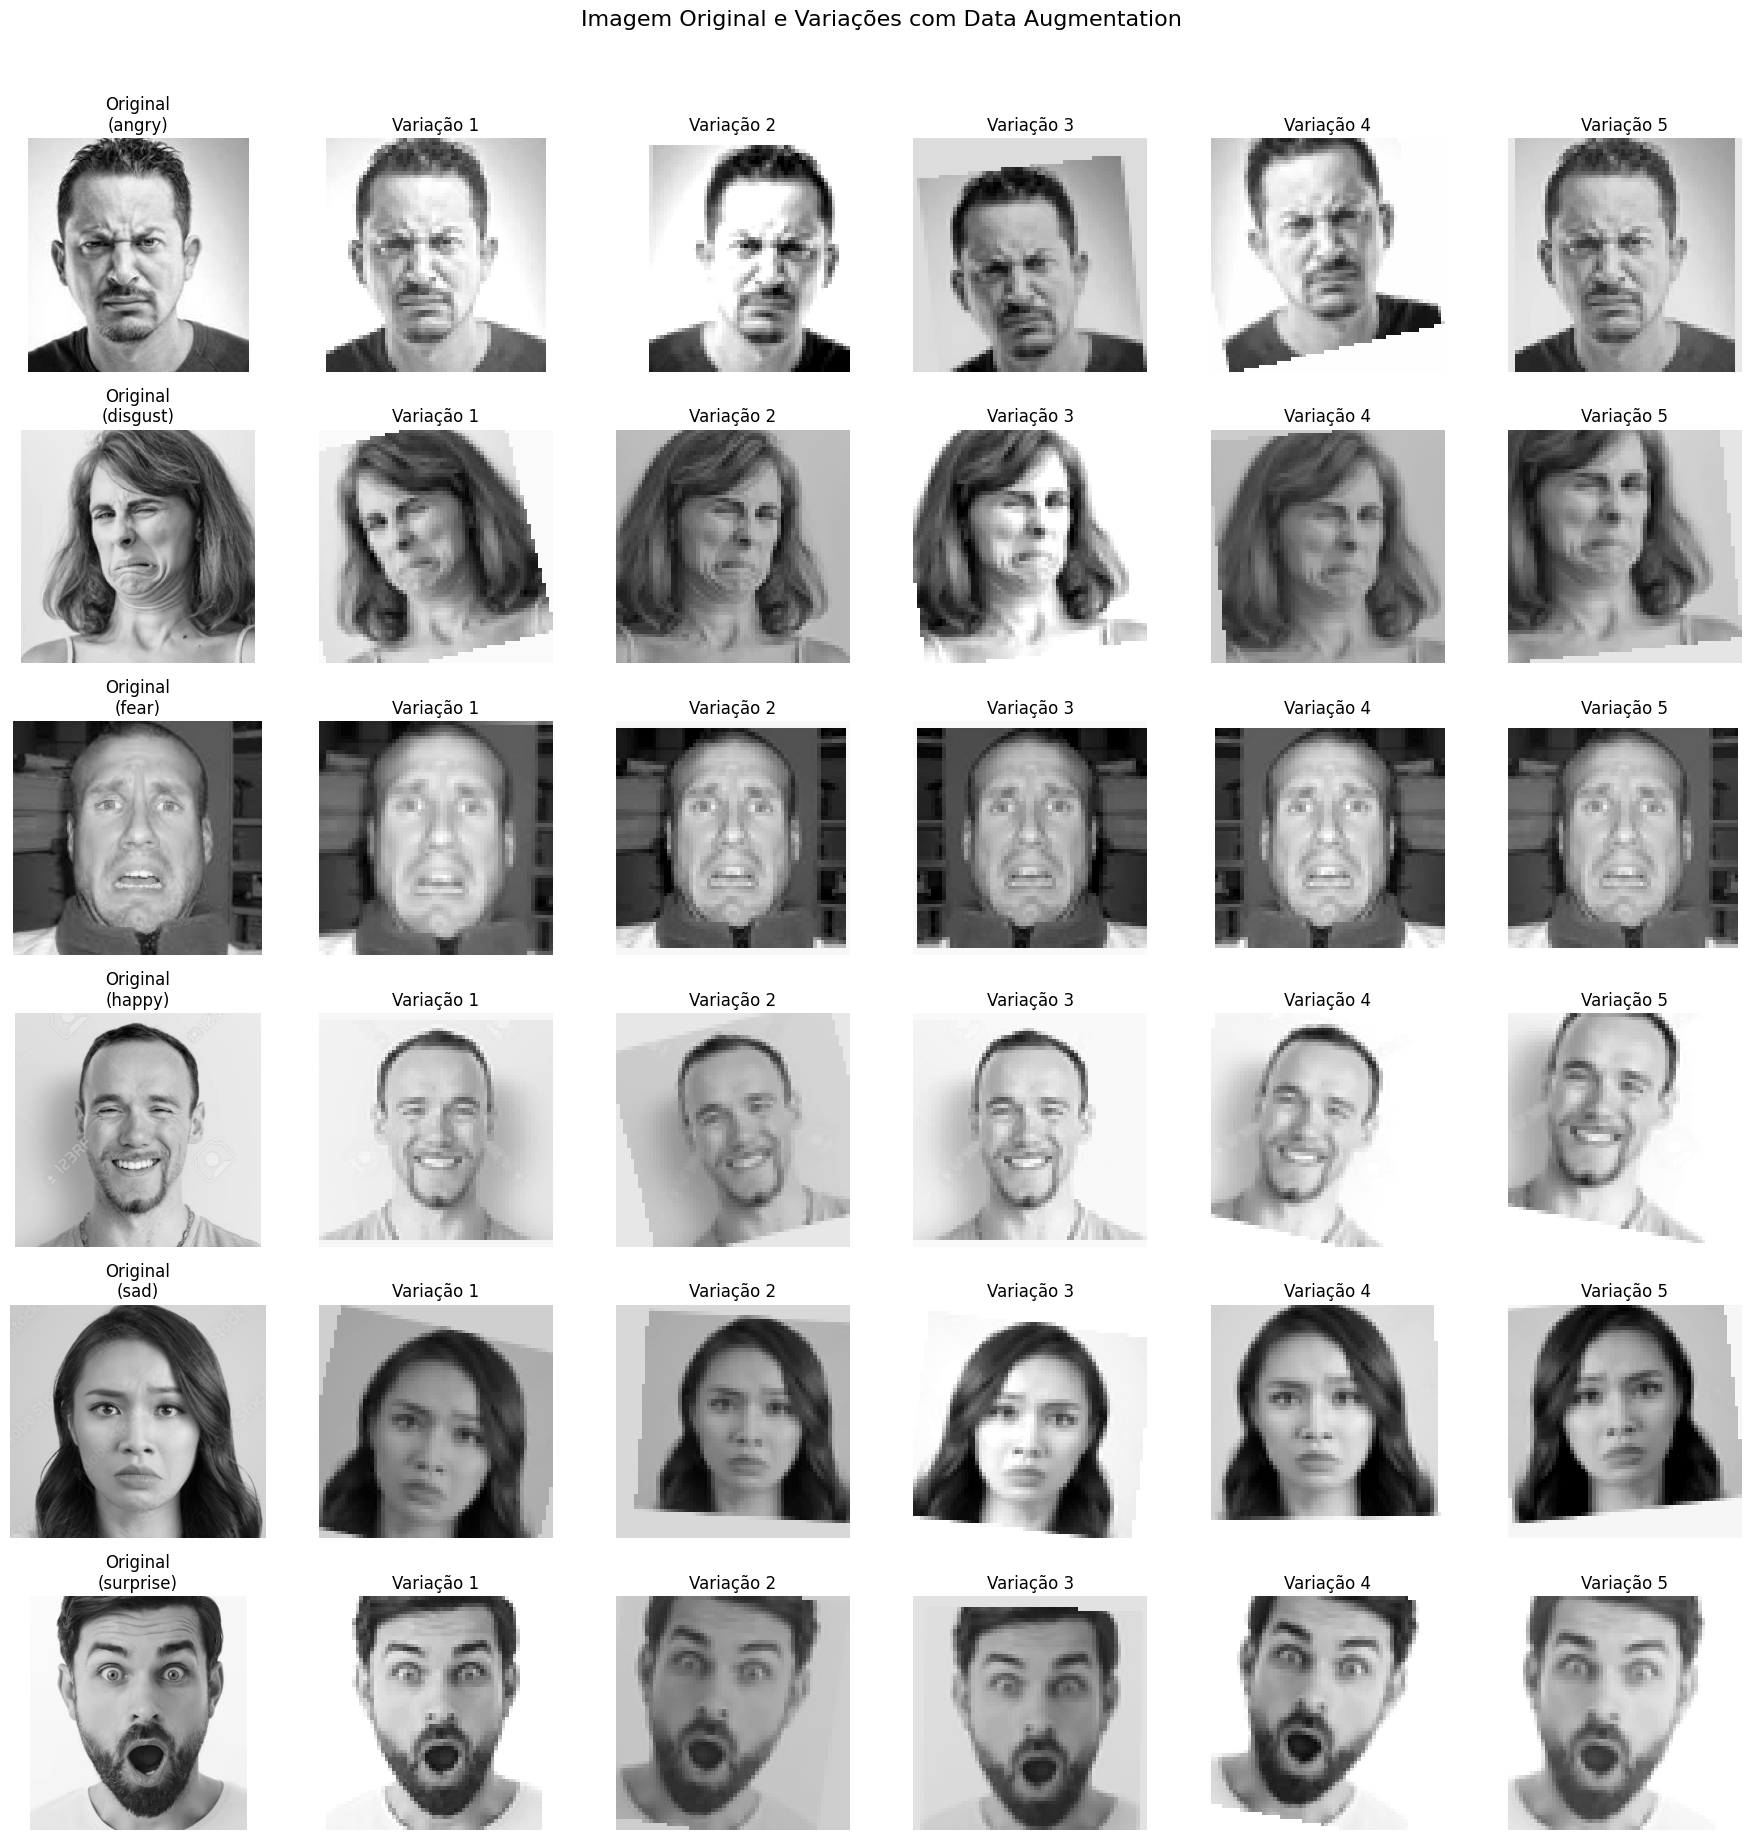

In [8]:
samples_por_classe = get_one_image_per_class(dataset)
visualizar_data_augmentation(dataset, samples=samples_por_classe, num_variacoes=5)